In [309]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib notebook

import plotly
import susipop as sp

from multiprocessing import Pool
from scipy.interpolate import griddata

from susipop.susi.cache import SusiCache as cache
import susipop as sp

from tqdm import *
from collections import defaultdict
from scipy.stats.stats import pearsonr   
plt.style.use('ggplot')
def get_folder_list():
    f = next(os.walk('.'))[1]
    return f

In [310]:
def get_particle_pairs_at_timestep(dataset,t,gap= 1e-8):
    dataset.load_state(dataset.tlist[t])
    ball_positions = dataset.particles.r
    sim_chars = sp.susi.extract_sim_characteristics(dataset)
    sim_chars["gap"] = gap
    sim_chars = sp.susi.extract_sim_characteristics(dataset, **sim_chars)
    particle_pairs = sp.spatial.cluster_analysis.find_particle_pairs_cluster(ball_positions=ball_positions,**sim_chars)
    return particle_pairs

def get_connectivity_degree(dataset=dataset,t=200,gap=9e-7):
    partid = get_particle_pairs_at_timestep(dataset,t,gap)
    partid = np.asarray(partid)
    part_db = {}
    for key in np.unique(np.unique(partid.T[0])):
        part_db[key] = np.unique(partid.T[1][np.where(partid.T[0] == key)[0]])
    degrees = [len(part_db[key]) for key in part_db] 
    return np.mean(degrees)

In [311]:
def get_connectivity(phivals,ydvals,gap=9e-8,step=50):
    plot_data = {}
    for i,phi in enumerate(tqdm(phivals)):
        plot_data[phi] = {}
        for yd in ydvals:
            path = "rhor1_phi"+str(phi)+"_yd"+str(yd)+"/"
            if os.path.exists(path):
                plot_data[phi][yd] = [[],[]]
                try:
                    dataset = sp.reader.DataSet(path, particles = True, fluid=False)
                    degree_list = []
                    stress_list = []
                    for t in range(100,len(dataset.tlist),step):
#                         print t
                        try:
                            degree_list.append(get_connectivity_degree(dataset=dataset,t=t,gap=gap))
                            stress_list.append(np.mean(map(np.linalg.norm, dataset.particles.sshear_tot)))
                        except Exception as e:
#                             print e
                            break
                    plot_data[phi][yd][0] = degree_list
                    plot_data[phi][yd][1] = stress_list
                except Exception as e:
                    break
    return plot_data
def plot_connectivity_data(plot_data,stress_on=False,degres_on=True):
    plt.figure(figsize=[10,5])
    for p in phivals:
        for y in ydvals:
            try:
                degrees = plot_data[p][y][0]
                stress = plot_data[p][y][1]
                if len(degrees)>0:
                    if degres_on: plt.plot(degrees,label="phi={0},yd={1} degrees".format(p,y))
                    if stress_on: plt.plot(stress/max(stress),label="phi={0},yd={1} normalized stress".format(p,y))
                    print pearsonr(degrees,stress)
            except:
                continue
#     plt.yscale("log")
    plt.xlabel("timeseries step")
    plt.legend(fontsize=8,ncol=2)
    plt.tight_layout()
    plt.show()

100%|██████████| 1/1 [01:09<00:00, 69.94s/it]


<IPython.core.display.Javascript object>


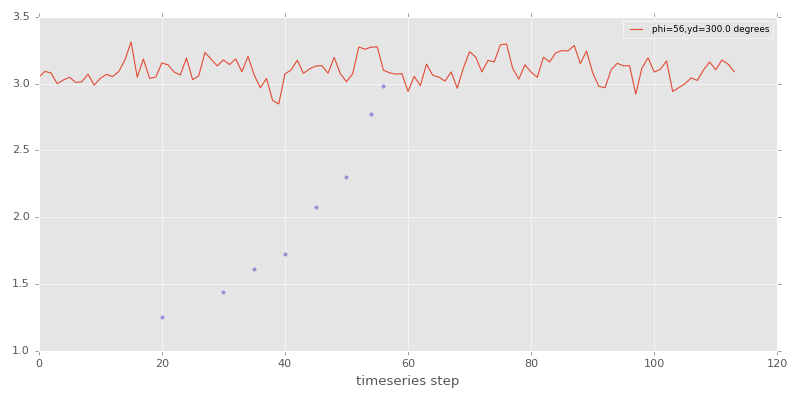

(0.68216430156914809, 6.4592146072794305e-17)


In [317]:
# phivals=range(20,57) 
phivals=[56]
# ydvals=[float(i) for i in range(1,1000)]
ydvals = [300.0]
plot_data = get_connectivity(phivals=phivals,ydvals=ydvals,gap=1e-7,step=50)
plot_connectivity_data(plot_data,stress_on=False,degres_on=True)

KeyError: 56

In [390]:
phiydlist = [[56,300.0],[55,300.0],[54,300.0],[50,300.0],[45,1000.0],[40,1000.0],[35,10000.0],[30,10000.0],[20,10000.0]]
philist = []
degreelist = []
stresslist = []
for item in phiydlist:
    phi,yd = item[0],item[1]
    print "phi={},yd={}".format(phi,yd)
    plot_data = get_connectivity(phivals=[phi],ydvals=[yd],gap=1e-7,step=10)
    degree =  plot_data[phi][yd][0]
    stress =  plot_data[phi][yd][1]
    philist.append(phi)
    degreelist.append(degree)
    stresslist.append(stress)

  0%|          | 0/1 [00:00<?, ?it/s]

phi=56,yd=300.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=55,yd=300.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=54,yd=300.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=50,yd=300.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=45,yd=1000.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=40,yd=1000.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=35,yd=10000.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=30,yd=10000.0


  0%|          | 0/1 [00:00<?, ?it/s]

phi=20,yd=10000.0


100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


<IPython.core.display.Javascript object>


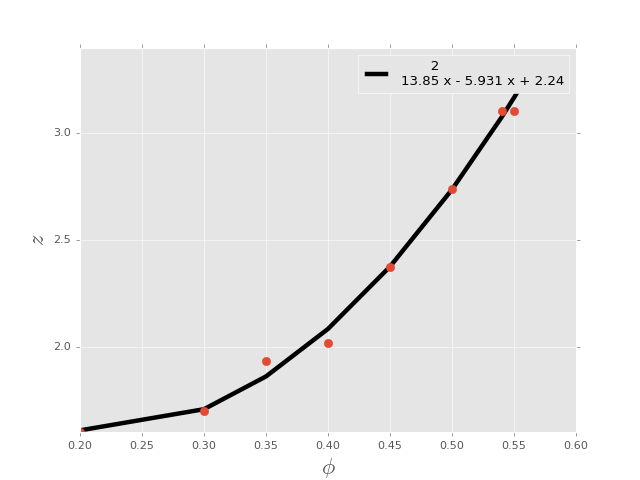

In [400]:
philist2 = np.array([i/100.0 for i in philist])
degrees2 = np.array([np.max(i) for i in degreelist])
func = np.poly1d(np.polyfit(philist2,degrees2,2))
# func = lambda x : 12.58*x**2-4.677*x+2.5
plt.figure()
plt.plot(philist2, func(philist2),'k-',linewidth=4, label=str(func))
plt.plot(philist2, degrees2,'.',markersize=15)
plt.legend()
plt.xlabel("$\phi$",fontsize=20)
plt.ylabel("$z$",fontsize=20)